# Paper plots and results

Notebook to reproduce some of the plots in Peirson, Liodakis & Romani (2022)

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('plot.mplstyle')
import numpy as np
from scipy import stats
from scipy import interpolate
from sscpol.jet_fns import *
from sscpol.fitter import SSC_Fitter
import multiprocess as mp
import pickle
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
sync_c = '#c5395a'
ic_c = '#0883a4'
data_dir = '/home/groups/rwr/alpv95/tracksml/moments/ixpeobssimdata/'

/tmp/ipykernel_249677/137364951.py:16: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,


## Define Plotting and Data functions

In [2]:
def get_blazar_fit(name,):
    samples_sync = np.load('../data/fits/syncs_'+ name+'.npy')
    samples_ic = np.load('../data/fits/ics_'+ name + '.npy')
    samples = [(sync,ic) for sync, ic in zip(samples_sync, samples_ic)]

    mu, sigma = pickle.load(open('../data/checkpoints/'+name+'.p', 'rb'))
    return samples, mu, sigma

In [3]:
def process_blazar(samples, d_blazar, z):
    dist_factor = 1.0E7*(1.0/((4.0*np.pi*d_blazar**2.0)*(1.0+z)**2.0))

    flog = np.linspace(-6,13, 900)
    f = np.logspace(-6,13, 900)
    interp_kind = 'quadratic'

    samples_full = []
    log_samples_full = []
    for S, IC in samples:
        IC[2:] *= 0.9
        Slog, IClog = np.log10(S), np.log10(IC)
        Tot = np.stack([f, 10**np.interp(flog, Slog[0], Slog[1]) + 10**np.interp(flog, IClog[0], IClog[1]),
                        interpolate.interp1d(S[0], S[2], fill_value=0, bounds_error=False, kind=interp_kind)(f)
                        + interpolate.interp1d(IC[0], IC[2], fill_value=0, bounds_error=False, kind=interp_kind)(f),
                        interpolate.interp1d(S[0], S[3], fill_value=0, bounds_error=False, kind=interp_kind)(f) 
                        + interpolate.interp1d(IC[0], IC[3], fill_value=0, bounds_error=False, kind=interp_kind)(f),])
        Scopy, ICcopy, Totcopy = S.copy(), IC.copy(), Tot.copy()
        Scopy[1:] = Scopy[1:] * dist_factor
        ICcopy[1:] = ICcopy[1:] * dist_factor
        Totcopy[1:] = Totcopy[1:] * dist_factor

        S_Pi = np.sqrt(Scopy[2]**2 + Scopy[3]**2) / Scopy[1]
        IC_Pi = np.sqrt(ICcopy[2]**2 + ICcopy[3]**2) / ICcopy[1]
        Tot_Pi = np.sqrt(Totcopy[2]**2 + Totcopy[3]**2) / Totcopy[1]

        S_PA = 0.5*np.arctan2(Scopy[3],Scopy[2])
        IC_PA = 0.5*np.arctan2(ICcopy[3],ICcopy[2])
        Tot_PA = 0.5*np.arctan2(Totcopy[3],Totcopy[2])

        Scopy[2] = S_Pi
        Scopy[3] = S_PA
        ICcopy[2] = IC_Pi
        ICcopy[3] = IC_PA
        Totcopy[2] = Tot_Pi
        Totcopy[3] = Tot_PA

        samples_full.append((Scopy,ICcopy,Totcopy))
        log_samples_full.append((np.log10(Scopy),np.log10(ICcopy),np.log10(Totcopy)))

    mean_funcS, mean_funcIC, mean_funcTot = [10**np.mean(i, axis=0) for i in zip(*log_samples_full)]
    std_upperS, std_upperIC, std_upperTot = [10**(np.mean(i, axis=0) + np.std(i, axis=0)) for i in zip(*log_samples_full)]
    std_lowerS, std_lowerIC, std_lowerTot = [10**(np.mean(i, axis=0) - np.std(i, axis=0)) for i in zip(*log_samples_full)]
    
    S = np.stack([mean_funcS,std_upperS,std_lowerS])
    IC = np.stack([mean_funcIC,std_upperIC,std_lowerIC])
    Tot = np.stack([mean_funcTot,std_upperTot,std_lowerTot])

    mean_funcS_lin, mean_funcIC_lin, mean_funcTot_lin = [np.mean(i, axis=0) for i in zip(*samples_full)]
    std_upperS_lin, std_upperIC_lin, std_upperTot_lin = [(np.mean(i, axis=0) + np.std(i, axis=0)) for i in zip(*samples_full)]
    std_lowerS_lin, std_lowerIC_lin, std_lowerTot_lin = [(np.mean(i, axis=0) - np.std(i, axis=0)) for i in zip(*samples_full)]
    
    S_lin = np.stack([mean_funcS_lin,std_upperS_lin,std_lowerS_lin])
    IC_lin = np.stack([mean_funcIC_lin,std_upperIC_lin,std_lowerIC_lin])
    Tot_lin = np.stack([mean_funcTot_lin,std_upperTot_lin,std_lowerTot_lin])
    
    return samples_full, (S, IC, Tot), (S_lin, IC_lin, Tot_lin)

In [4]:
def get_data():
    data = []
    pols = [(0.231,0.0693),(0.231,0.0693),
            (0.109,0.0489),(0.109,0.0489),(0.09,0.0589)]
    distances = [(1000E6*3.08E18, 0.2),(1000E6*3.08E18, 0.2),
            (1627E6*3.08E18,0.31 ),(1627E6*3.08E18,0.31 ),
            (1789E6*3.08E18, 0.3365)]
    #flare
    d = np.loadtxt('../data/new_data_sed_CGRaBSJ0211+1051.txt')
    d_xmm = np.loadtxt('../data/CGRaBSJ02111051-builderX.txt')
    data.append(np.concatenate([d,d_xmm], axis=0))
    #no flare
    d = np.loadtxt('../data/new_data_sed_CGRaBSJ0211+1051.txt')
    d_xmm = np.loadtxt('../data/new_data_sed_CGRaBSJ0211+1051_XMM.txt')
    data.append(np.concatenate([d,d_xmm], axis=0))
    #flare
    data.append(np.loadtxt('../data/S5flare.txt'))
    #no flare
    d = np.loadtxt('../data/S5low.txt')
    data.append(np.insert(d, 1, 0, axis=1))
    #flare
    d = np.loadtxt('../data/txs.txt')
    data.append(np.insert(d, 1, 0, axis=1))

    return data, pols, distances

In [5]:
def plot_blazar_pols(samples, fig, ax, pols, save=None, **kwargs):    
    for a, d in zip(ax,pols):
        _plot_pol_data(a, d)
    i = 0
    for s, a, d, iters, name in zip(samples, ax, kwargs.get('distances'), kwargs.get('iters'), kwargs.get('names')):
        labels = [None]*3
        if i == 0:
            i+=1
            labels = ('Synchrotron','SSC', 'Total')
        _single_plot_pol(s, a, *d, it=iters, name=name, labels=labels, **kwargs)
   
    _settings_pol(fig, ax, save, **kwargs)

In [6]:
def plot_blazar_SEDs(samples, fig, ax, data, n_blazars, save=None, **kwargs):    
    for a, d in zip(zip(ax[:n_blazars],ax[n_blazars:]),data):
        _plot_sed_data(a, d)
    i = 0
    for s, a, d, name in zip(samples,zip(ax[:n_blazars],ax[n_blazars:]),kwargs.get('distances'), kwargs.get('names')):
        labels = [None]*3
        if i == 0:
            i+=1
            labels = ('Synchrotron','SSC', 'Total')
        _single_plot_SED(s, a, *d, name=name, labels=labels, **kwargs)
        
    _settings_sed(fig, ax, n_blazars, save, **kwargs)

In [7]:
def _plot_sed_data(ax, data):
    (ax3,ax4) = ax
    ax3.errorbar(10**data[:,0], 10**data[:,2],
            yerr=np.stack([np.abs(10**data[:,2] - 10**(data[:,2] - data[:,3])),np.abs(10**data[:,2] - 10**(data[:,2] + data[:,3]))]),
            markersize=2, ls="", marker='^',color='k')
    ip = InsetPosition(ax3, [0.63,0.16,0.25,0.35])
    ax4.set_axes_locator(ip)
    mark_inset(ax3, ax4, loc1=1, loc2=3, fc="none", ec='0.8')
    
    ax4.errorbar(10**data[:,0], 10**data[:,2],
            yerr=np.stack([np.abs(10**data[:,2] - 10**(data[:,2] - data[:,3])),np.abs(10**data[:,2] - 10**(data[:,2] + data[:,3]))]),
            markersize=2, ls="", marker='^',color='k')

In [8]:
def _plot_pol_data(ax, pol):
    ax.errorbar(1.9, pol[0], yerr=pol[1], ls="", marker='^',color='k', markersize=2,)

In [9]:
def _settings_sed(fig, ax, n_blazars, save=None, **kwargs):
    for i,ax3 in enumerate(ax[:n_blazars]):
        ax3.axvline(1e3,color='lightgrey'); ax3.axvline(1e4,color='lightgrey')
        ax3.set_yscale('log')
        ax3.set_ylim(*kwargs['flux_ylim'][i])
        ax3.set_xscale('log')
        ax3.set_xlim(5e-5, 1e13)
        if kwargs.get('xlabel'):
            ax3.set_xlabel(r"$h\nu$ [eV]")
        ax3.set_ylabel(r"$\nu F_{\nu}$ $[ergs^{-1}cm^{-2}]$")
        leg = ax3.legend(loc=3)
        for line, text in zip(leg.get_lines(),leg.get_texts()):
            text.set_color(line.get_color())

    for i,ax4 in enumerate(ax[n_blazars:]):
        ax4.set_xscale('log')
        ax4.set_xlim(1e3, 1e4)
        ax4.set_yscale('log')
        ax4.set_ylim(*kwargs['inset_ylim'][i])
        
    if save is not None:
        fig.savefig("plots/" + save + ".pdf",format="pdf", bbox_inches="tight")

In [10]:
def _settings_pol(fig, ax, save=None, **kwargs):
    for ax1 in ax:
        ax1.set_xscale('log')
        ax1.axvline(1e3,color='lightgrey'); ax1.axvline(1e4,color='lightgrey')
        ax1.set_xlim(5e-2, 1e6)
        ax1.set_ylim(0.0, 0.49)
        ax1.set_ylabel(r"$p_0$")
        if kwargs.get('xlabel'):
            ax1.set_xlabel(r"$h\nu$ [eV]")
            
        leg = ax1.legend(loc=2)
        for line, text in zip(leg.get_lines(),leg.get_texts()):
            text.set_color(line.get_color())    

    if save is not None:
        fig.savefig("plots/" + save + ".pdf",format="pdf", bbox_inches="tight")

In [11]:
def _single_plot_pol(samples, ax, d_blazar, z, it, name, labels=('Synchrotron','SSC', 'Total'), 
                     fill_c='k', **kwargs):
    samples_full, (Smean, ICmean, Totmean), (Smean_lin, ICmean_lin, Totmean_lin)= process_blazar(samples, d_blazar, z)
    alpha = kwargs.get('alpha')
    ax.annotate(name, xy=(0.7,0.84),xycoords="axes fraction")
    
    ax.plot(Smean_lin[0,0], Smean_lin[0,2], color=sync_c, ls='--',label=labels[0], alpha=alpha)
    ax.plot(ICmean_lin[0,0], ICmean_lin[0,2], color=ic_c, ls=':',label=labels[1], alpha=alpha)
    ax.plot(Totmean_lin[0,0], Totmean_lin[0,2], color='k', ls='-',zorder=10,label=labels[2], alpha=alpha)
    ax.fill_between(Totmean_lin[0,0], Totmean_lin[1,2], Totmean_lin[2,2],color=fill_c,alpha=0.1)
    print("ratio: ", ICmean_lin[0,2][19]/Smean_lin[0,2][25])
    
    if kwargs.get('save_data'):
        np.save(data_dir + "blazars" +'/S_'+name, np.stack([Smean[0,0],Smean[0,1],Smean_lin[0,2],Smean_lin[0,3]]))
        np.save(data_dir + "blazars" +'/IC_'+name, np.stack([ICmean[0,0],ICmean[0,1],ICmean_lin[0,2],ICmean_lin[0,3]]))
        np.save(data_dir + "blazars" +'/Tot_'+name, np.stack([Totmean[0,0],Totmean[0,1],Totmean_lin[0,2],Totmean_lin[0,3]]))
    
    pi_2_4_list = []
    pi_4_8_list = []
    for i,idx in enumerate(it):
        S, IC, Tot = samples_full[idx]
        labels = [None]*3

        ax.plot(S[0], S[2], color=sync_c, ls='--',label=labels[0], alpha=0.4)
        ax.plot(IC[0], IC[2], color=ic_c, ls=':',label=labels[1], alpha=0.4)
        ax.plot(Tot[0], Tot[2], color='k', ls='-',zorder=10,label=labels[2], alpha=0.4)
        
        mask = (Tot[0] < 4e3) * (Tot[0] >= 2e3)
        pi_2_4_list.append(np.sqrt(np.sum(Tot[0][mask] * Tot[1][mask] * Tot[2][mask] * np.cos(2*Tot[3][mask]))**2 
                    + np.sum(Tot[0][mask] * Tot[1][mask] * Tot[2][mask] * np.sin(2*Tot[3][mask]))**2)
          / np.sum(Tot[0][mask] * Tot[1][mask]))
        
        mask = (Tot[0] < 8e3) * (Tot[0] >= 4e3)
        pi_4_8_list.append(np.sqrt(np.sum(Tot[0][mask] * Tot[1][mask] * Tot[2][mask] * np.cos(2*Tot[3][mask]))**2 
                    + np.sum(Tot[0][mask] * Tot[1][mask] * Tot[2][mask] * np.sin(2*Tot[3][mask]))**2)
          / np.sum(Tot[0][mask] * Tot[1][mask]))
        
        if kwargs.get('save_data'):
            np.save(data_dir + "blazars" +'/S_'+name+"_"+str(i), S)
            np.save(data_dir + "blazars" +'/IC_'+name+"_"+str(i), IC)
            np.save(data_dir + "blazars" +'/Tot_'+name+"_"+str(i), Tot)
    if kwargs.get('save_data'):
        np.save(data_dir + "blazars" +'/pi_'+name, np.stack([pi_2_4_list,pi_4_8_list]))
    

In [12]:
def _single_plot_SED(samples, ax, d_blazar, z, name, labels=('Synchrotron','SSC', 'Total'), fill_c='k', **kwargs):
    samples_full, (Smean, ICmean, Totmean), (_, _, _)= process_blazar(samples, d_blazar, z)
    alpha = kwargs.get('alpha')
    (ax3,ax4) = ax
    ax3.annotate(name, xy=(0.7,0.84),xycoords="axes fraction")
    
    ax3.plot(Smean[0,0], Smean[0,1], color=sync_c, ls='--',label=labels[0], alpha=alpha)
    ax3.plot(ICmean[0,0], ICmean[0,1], color=ic_c, ls=':',label=labels[1], alpha=alpha)
    ax3.plot(Totmean[0,0], Totmean[0,1], color='k', ls='-',zorder=10,label=labels[2], alpha=alpha)
    ax3.fill_between(Totmean[0,0], Totmean[1,1], Totmean[2,1],color=fill_c,alpha=0.2)

    ax4.plot(Smean[0,0][(Smean[0,0] > 1E2) * (Smean[0,0] <= 1E5)], Smean[0,1][(Smean[0,0] > 1E2) * (Smean[0,0] <= 1E5)], 
             color=sync_c, ls='--',label=labels[0], alpha=alpha)
    ax4.plot(ICmean[0,0][(ICmean[0,0] > 1E2) * (ICmean[0,0] <= 1E5)], ICmean[0,1][(ICmean[0,0] > 1E2) * (ICmean[0,0] <= 1E5)], 
             color=ic_c, ls=':',label=labels[1], alpha=alpha)
    ax4.plot(Totmean[0,0][(Totmean[0,0] > 1E2) * (Totmean[0,0] <= 1E5)], Totmean[0,1][(Totmean[0,0] > 1E2) * (Totmean[0,0] <= 1E5)], 
             color='k', ls='-',zorder=10,label=labels[2], alpha=alpha)
    ax4.fill_between(Totmean[0,0], Totmean[1,1], Totmean[2,1],color=fill_c,alpha=0.2)

In [13]:
def plot_blazar(samples, fig, ax, data, pol, d_blazar, z, save=None, **kwargs):
    (ax1,ax2,ax3,ax4) = ax
    
    _plot_sed_data((ax3,ax4), data)
    _plot_pol_data(ax1, pol)
    
    _single_plot(samples[0], d_blazar, z, **kwargs)
#     _single_plot(samples[1], d_blazar, z , labels=[None]*3, fill_c=ic_c, **kwargs)
    
    _settings(fig, (ax1,ax2,ax3,ax4), save, **kwargs)

In [14]:
def _single_plot(samples, d_blazar, z, labels=('Synchrotron','SSC', 'Total'), fill_c='k', **kwargs):
    samples_full, (_, _, Totmean), (Smean_lin, _, Totmean_lin)= process_blazar(samples, d_blazar, z)
    alpha = kwargs.get('alpha')
    iterator = np.random.choice(len(samples_full), kwargs['n_samples'], replace=False)
    if kwargs.get('iters'):
        iterator = kwargs.get('iters')
        
    for i, idx in enumerate(iterator):
        S, IC, Tot = samples_full[idx]
        if i > 0:
            labels = [None]*3

        ax3.plot(S[0], S[1], color=sync_c, ls='--',label=labels[0], alpha=alpha)
        ax3.plot(IC[0], IC[1], color=ic_c, ls=':',label=labels[1], alpha=alpha)
        ax3.plot(Tot[0], Tot[1], color='k', ls='-',zorder=10,label=labels[2], alpha=alpha)

        ax2.plot(S[0], S[3], color=sync_c, ls='--',label=labels[0], alpha=alpha)
    #     ax2.plot(IC[0], IC[3], color=ic_c, ls=':',label=labels[1], alpha=alpha)
        ax2.plot(Tot[0], Tot[3], color='k', ls='-',zorder=10,label=labels[2], alpha=alpha)

        ax1.plot(S[0], S[2], color=sync_c, ls='--',label=labels[0], alpha=alpha)
    #     ax1.plot(IC[0], IC[2], color=ic_c, ls=':',label=labels[1], alpha=alpha)
        ax1.plot(Tot[0], Tot[2], color='k', ls='-',zorder=10,label=labels[2], alpha=alpha)
        print(idx, "ratio: ", IC[2][19]/S[2][25])

        ax4.plot(S[0][(S[0] > 1E2) * (S[0] <= 1E5)], S[1][(S[0] > 1E2) * (S[0] <= 1E5)], 
                 color=sync_c, ls='--',label=labels[0])
        ax4.plot(IC[0][(IC[0] > 1E2) * (IC[0] <= 1E5)], IC[1][(IC[0] > 1E2) * (IC[0] <= 1E5)], 
                 color=ic_c, ls=':',label=labels[1])
        ax4.plot(Tot[0][(Tot[0] > 1E2) * (Tot[0] <= 1E5)], Tot[1][(Tot[0] > 1E2) * (Tot[0] <= 1E5)], 
                 color='k', ls='-',zorder=10,label=labels[2])
        ax4.fill_between(Tot[0], Totmean[1,1], Totmean[2,1],color=fill_c,alpha=0.1)
        
    ax3.fill_between(Tot[0], Totmean[1,1], Totmean[2,1],color=fill_c,alpha=0.1)
    ax1.fill_between(Tot[0], Totmean[1,2], Totmean[2,2],color=fill_c,alpha=0.1)
#     ax2.fill_between(S[0], Smean_lin[1,3], Smean_lin[2,3],color=fill_c,alpha=0.1)

In [15]:
def _settings(fig, ax, save=None, **kwargs):
    (ax1,ax2,ax3,ax4) = ax
    
    ax4.set_xscale('log')
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax4.set_xlim(1e3, 1e4)
    ax3.axvline(1e3,color='lightgrey'); ax3.axvline(1e4,color='lightgrey')
    ax2.axvline(1e3,color='lightgrey'); ax2.axvline(1e4,color='lightgrey')
    ax1.axvline(1e3,color='lightgrey'); ax1.axvline(1e4,color='lightgrey')

    # for i, (text, unit) in enumerate(zip(varlabels, units)):
    #     ax3.annotate(fr'${text} = {mu[i]:.2f} \pm {np.sqrt(sigma[i,i]):.2f} {unit}$',
    #             xy=(1.01,0.9 - 0.08*i), xycoords='axes fraction', fontsize=7)

    for ax in [ax3]:
        ax.set_xscale('log')
        ax.set_xlim(5e-5, 1e13)

    ax3.set_yscale('log')
    ax4.set_yscale('log')
    ax3.set_ylim(*kwargs['flux_ylim'])
    ax4.set_ylim(*kwargs['inset_ylim'])
    ax1.set_ylim(0.0, 0.5)
    ax2.set_ylim(-np.pi/2, np.pi/2)

    ax1.tick_params(labelbottom=False)
    ax2.tick_params(labelbottom=False)
    # ax3.grid()
    leg = ax3.legend(loc=3)
    for line, text in zip(leg.get_lines(),leg.get_texts()):
        text.set_color(line.get_color())
    
    if kwargs.get('ylabel'):
        ax1.set_ylabel(r"$p_0$")
        ax2.set_ylabel(r"$\phi$ [rad]")
        ax3.set_ylabel(r"$\nu F_{\nu}$ $[ergs^{-1}cm^{-2}]$")
    ax3.set_xlabel(r"$h\nu$ [eV]")
    if save is not None:
        fig.savefig("plots/" + save + ".pdf",format="pdf", bbox_inches="tight")

## SED single-panel

/tmp/ipykernel_132379/2659260178.py:12: RuntimeWarning: invalid value encountered in log10
  Slog, IClog = np.log10(S), np.log10(IC)
/tmp/ipykernel_132379/2659260178.py:12: RuntimeWarning: divide by zero encountered in log10
  Slog, IClog = np.log10(S), np.log10(IC)
/tmp/ipykernel_132379/2659260178.py:24: RuntimeWarning: invalid value encountered in true_divide
  IC_Pi = np.sqrt(ICcopy[2]**2 + ICcopy[3]**2) / ICcopy[1]
/tmp/ipykernel_132379/2659260178.py:39: RuntimeWarning: invalid value encountered in log10
  log_samples_full.append((np.log10(Scopy),np.log10(ICcopy),np.log10(Totcopy)))
/tmp/ipykernel_132379/2659260178.py:39: RuntimeWarning: divide by zero encountered in log10
  log_samples_full.append((np.log10(Scopy),np.log10(ICcopy),np.log10(Totcopy)))
/share/software/user/open/py-numpy/1.20.3_py39/lib/python3.9/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
2022-04-13 11:49:14,542 - matplotlib.font_man

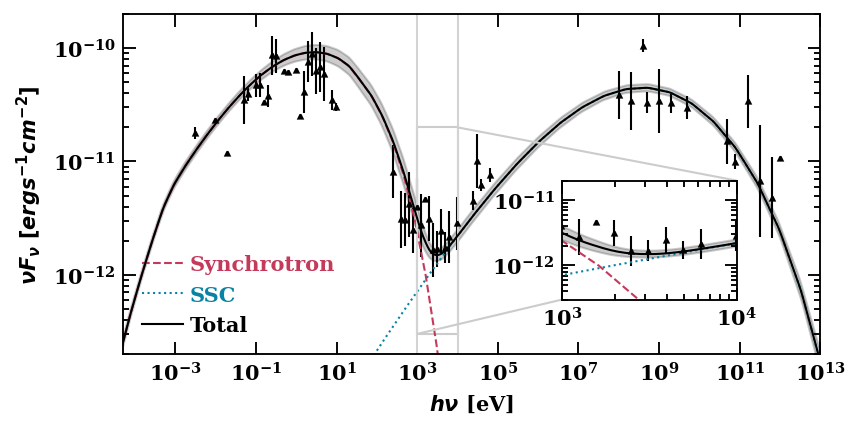

In [16]:
name = 'SED_single'
names = ['J2011flare_19_g','J2011_19_g','S5flare_37_g','S5low_37_g','TXS_37_g']
samples = []
for n in names:
    s, mu, sigma = get_blazar_fit(n + '0',)
    samples.append(s)

# names_plot = ['J0211-flare','J0211','S50716-flare','S50716','TXS0506-flare']
names_plot = ['J0211+1051(f)', 'J0211+1051', 'S5 0716+716(f)', 'S5 0716+716', 'TXS 0506+056(f)']

fig, ax  = plt.subplots(figsize=(6,3), nrows=1, sharex=True,)
#                                   gridspec_kw={'hspace': 0, 'height_ratios': (0.2,0.2,0.2,0.2,0.2)})
# ax = list(ax)
ax = [ax]
for _ in range(len(ax)):
    ax.append(plt.axes([0,0,1,1]))

data,_,distances = get_data()
inset_ylim = [(3e-13, 5e-12),(1e-13, 2e-12),(1e-12, 2.5e-11),(3e-13, 2e-11),(2e-13, 9e-12)]
flux_ylim = [(5e-14, 1e-10),(5e-14, 8e-11),(1e-12, 5e-10),(2e-13, 2e-10),(5e-14, 5e-11)]


kwargs = dict(inset_ylim=[inset_ylim[3]], flux_ylim=[flux_ylim[3]], names=[None], 
              xlabel=True, distances=[distances[3]])

# samples = [samples_jf,samples_j,samples_sf,samples_s,samples_x]

plot_blazar_SEDs([samples[3]], fig, ax, data=[data[3]], n_blazars=1, save=name,**kwargs)

## SED multi-panel

/tmp/ipykernel_27430/2659260178.py:12: RuntimeWarning: invalid value encountered in log10
  Slog, IClog = np.log10(S), np.log10(IC)
/tmp/ipykernel_27430/2659260178.py:12: RuntimeWarning: divide by zero encountered in log10
  Slog, IClog = np.log10(S), np.log10(IC)
/tmp/ipykernel_27430/2659260178.py:24: RuntimeWarning: invalid value encountered in true_divide
  IC_Pi = np.sqrt(ICcopy[2]**2 + ICcopy[3]**2) / ICcopy[1]
/tmp/ipykernel_27430/2659260178.py:39: RuntimeWarning: divide by zero encountered in log10
  log_samples_full.append((np.log10(Scopy),np.log10(ICcopy),np.log10(Totcopy)))
/tmp/ipykernel_27430/2659260178.py:39: RuntimeWarning: invalid value encountered in log10
  log_samples_full.append((np.log10(Scopy),np.log10(ICcopy),np.log10(Totcopy)))
/tmp/ipykernel_27430/2659260178.py:23: RuntimeWarning: invalid value encountered in true_divide
  S_Pi = np.sqrt(Scopy[2]**2 + Scopy[3]**2) / Scopy[1]
/share/software/user/open/py-numpy/1.20.3_py39/lib/python3.9/site-packages/numpy/core/_m

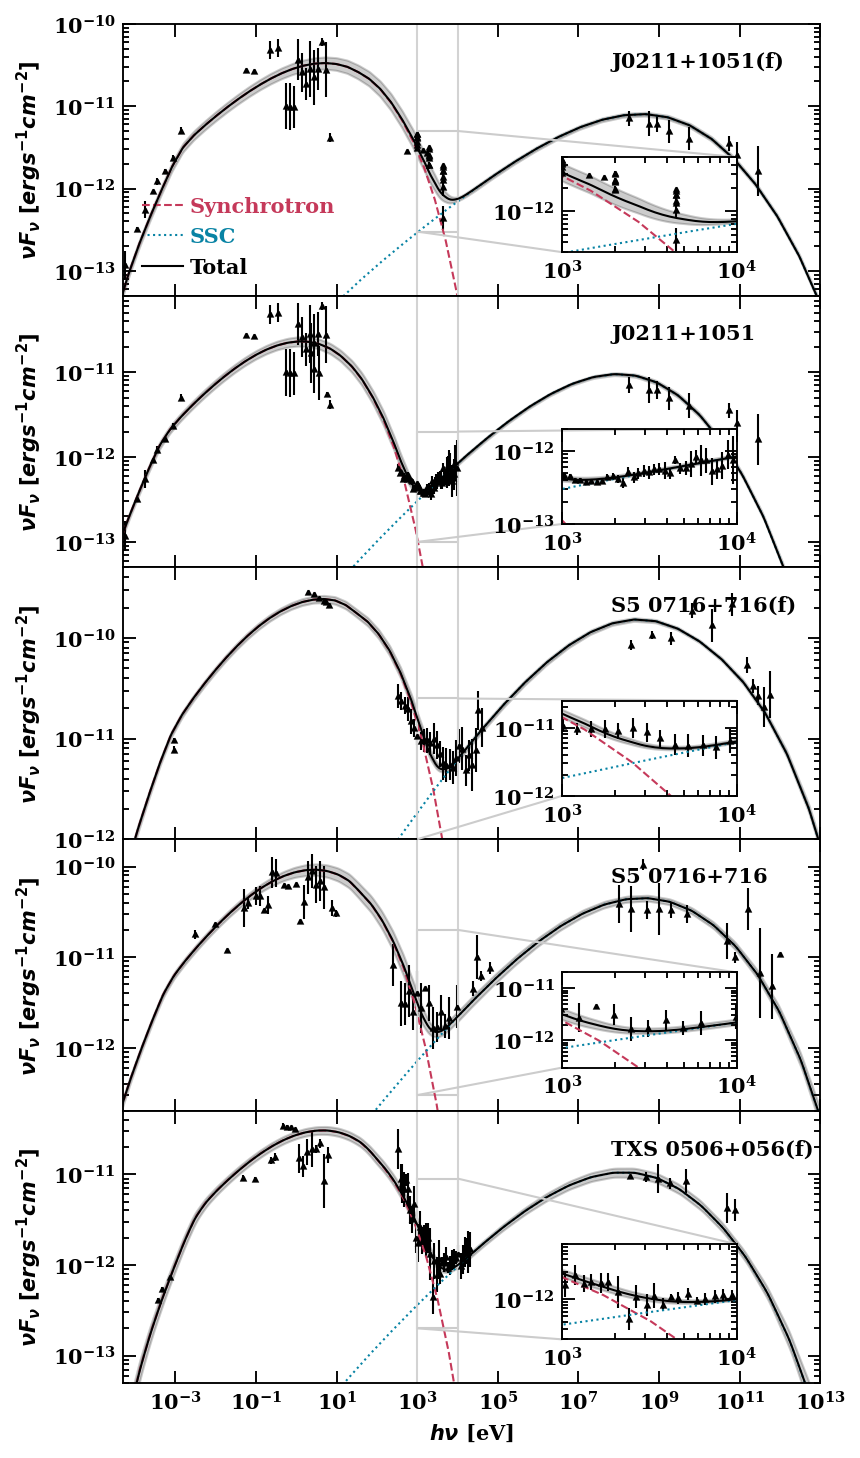

In [18]:
name = 'SED_all'
names = ['J2011flare_19_g','J2011_19_g','S5flare_37_g','S5low_37_g','TXS_37_g']
samples = []
for n in names:
    s, mu, sigma = get_blazar_fit(n + '0',)
    samples.append(s)

# names_plot = ['J0211-flare','J0211','S50716-flare','S50716','TXS0506-flare']
names_plot = ['J0211+1051(f)', 'J0211+1051', 'S5 0716+716(f)', 'S5 0716+716', 'TXS 0506+056(f)']

fig, ax  = plt.subplots(figsize=(6,12), nrows=5, sharex=True,
                                  gridspec_kw={'hspace': 0, 'height_ratios': (0.2,0.2,0.2,0.2,0.2)})
ax = list(ax)
# ax = [ax]
for _ in range(len(ax)):
    ax.append(plt.axes([0,0,1,1]))

data,_,distances = get_data()
inset_ylim = [(3e-13, 5e-12),(1e-13, 2e-12),(1e-12, 2.5e-11),(3e-13, 2e-11),(2e-13, 9e-12)]
flux_ylim = [(5e-14, 1e-10),(5e-14, 8e-11),(1e-12, 5e-10),(2e-13, 2e-10),(5e-14, 5e-11)]


kwargs = dict(inset_ylim=inset_ylim, flux_ylim=flux_ylim, names=names_plot, 
              xlabel=True, distances=distances)

# samples = [samples_jf,samples_j,samples_sf,samples_s,samples_x]

plot_blazar_SEDs(samples, fig, ax, data=data, n_blazars=5, save=name,**kwargs)

## Polarization Multi-panel

/tmp/ipykernel_27430/2659260178.py:12: RuntimeWarning: invalid value encountered in log10
  Slog, IClog = np.log10(S), np.log10(IC)
/tmp/ipykernel_27430/2659260178.py:12: RuntimeWarning: divide by zero encountered in log10
  Slog, IClog = np.log10(S), np.log10(IC)
/tmp/ipykernel_27430/2659260178.py:24: RuntimeWarning: invalid value encountered in true_divide
  IC_Pi = np.sqrt(ICcopy[2]**2 + ICcopy[3]**2) / ICcopy[1]
/tmp/ipykernel_27430/2659260178.py:39: RuntimeWarning: divide by zero encountered in log10
  log_samples_full.append((np.log10(Scopy),np.log10(ICcopy),np.log10(Totcopy)))
/tmp/ipykernel_27430/2659260178.py:39: RuntimeWarning: invalid value encountered in log10
  log_samples_full.append((np.log10(Scopy),np.log10(ICcopy),np.log10(Totcopy)))
/tmp/ipykernel_27430/2659260178.py:23: RuntimeWarning: invalid value encountered in true_divide
  S_Pi = np.sqrt(Scopy[2]**2 + Scopy[3]**2) / Scopy[1]
/share/software/user/open/py-numpy/1.20.3_py39/lib/python3.9/site-packages/numpy/core/_m

ratio:  0.3457049942657667


/tmp/ipykernel_27430/2659260178.py:12: RuntimeWarning: divide by zero encountered in log10
  Slog, IClog = np.log10(S), np.log10(IC)
/tmp/ipykernel_27430/2659260178.py:12: RuntimeWarning: invalid value encountered in log10
  Slog, IClog = np.log10(S), np.log10(IC)
/tmp/ipykernel_27430/2659260178.py:23: RuntimeWarning: invalid value encountered in true_divide
  S_Pi = np.sqrt(Scopy[2]**2 + Scopy[3]**2) / Scopy[1]
/tmp/ipykernel_27430/2659260178.py:24: RuntimeWarning: invalid value encountered in true_divide
  IC_Pi = np.sqrt(ICcopy[2]**2 + ICcopy[3]**2) / ICcopy[1]
/tmp/ipykernel_27430/2659260178.py:39: RuntimeWarning: divide by zero encountered in log10
  log_samples_full.append((np.log10(Scopy),np.log10(ICcopy),np.log10(Totcopy)))
/tmp/ipykernel_27430/2659260178.py:39: RuntimeWarning: invalid value encountered in log10
  log_samples_full.append((np.log10(Scopy),np.log10(ICcopy),np.log10(Totcopy)))
/share/software/user/open/py-numpy/1.20.3_py39/lib/python3.9/site-packages/numpy/core/_m

ratio:  0.3087447534857358


/tmp/ipykernel_27430/2659260178.py:12: RuntimeWarning: invalid value encountered in log10
  Slog, IClog = np.log10(S), np.log10(IC)
/tmp/ipykernel_27430/2659260178.py:12: RuntimeWarning: divide by zero encountered in log10
  Slog, IClog = np.log10(S), np.log10(IC)
/tmp/ipykernel_27430/2659260178.py:24: RuntimeWarning: invalid value encountered in true_divide
  IC_Pi = np.sqrt(ICcopy[2]**2 + ICcopy[3]**2) / ICcopy[1]
/tmp/ipykernel_27430/2659260178.py:39: RuntimeWarning: invalid value encountered in log10
  log_samples_full.append((np.log10(Scopy),np.log10(ICcopy),np.log10(Totcopy)))
/tmp/ipykernel_27430/2659260178.py:39: RuntimeWarning: divide by zero encountered in log10
  log_samples_full.append((np.log10(Scopy),np.log10(ICcopy),np.log10(Totcopy)))
/share/software/user/open/py-numpy/1.20.3_py39/lib/python3.9/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


ratio:  0.3384531354159681


/tmp/ipykernel_27430/2659260178.py:12: RuntimeWarning: invalid value encountered in log10
  Slog, IClog = np.log10(S), np.log10(IC)
/tmp/ipykernel_27430/2659260178.py:12: RuntimeWarning: divide by zero encountered in log10
  Slog, IClog = np.log10(S), np.log10(IC)
/tmp/ipykernel_27430/2659260178.py:24: RuntimeWarning: invalid value encountered in true_divide
  IC_Pi = np.sqrt(ICcopy[2]**2 + ICcopy[3]**2) / ICcopy[1]
/tmp/ipykernel_27430/2659260178.py:39: RuntimeWarning: invalid value encountered in log10
  log_samples_full.append((np.log10(Scopy),np.log10(ICcopy),np.log10(Totcopy)))
/tmp/ipykernel_27430/2659260178.py:39: RuntimeWarning: divide by zero encountered in log10
  log_samples_full.append((np.log10(Scopy),np.log10(ICcopy),np.log10(Totcopy)))
/share/software/user/open/py-numpy/1.20.3_py39/lib/python3.9/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


ratio:  0.34108497223769274


/tmp/ipykernel_27430/2659260178.py:12: RuntimeWarning: divide by zero encountered in log10
  Slog, IClog = np.log10(S), np.log10(IC)
/tmp/ipykernel_27430/2659260178.py:12: RuntimeWarning: invalid value encountered in log10
  Slog, IClog = np.log10(S), np.log10(IC)
/tmp/ipykernel_27430/2659260178.py:23: RuntimeWarning: invalid value encountered in true_divide
  S_Pi = np.sqrt(Scopy[2]**2 + Scopy[3]**2) / Scopy[1]
/tmp/ipykernel_27430/2659260178.py:24: RuntimeWarning: invalid value encountered in true_divide
  IC_Pi = np.sqrt(ICcopy[2]**2 + ICcopy[3]**2) / ICcopy[1]
/tmp/ipykernel_27430/2659260178.py:39: RuntimeWarning: divide by zero encountered in log10
  log_samples_full.append((np.log10(Scopy),np.log10(ICcopy),np.log10(Totcopy)))
/tmp/ipykernel_27430/2659260178.py:39: RuntimeWarning: invalid value encountered in log10
  log_samples_full.append((np.log10(Scopy),np.log10(ICcopy),np.log10(Totcopy)))
/share/software/user/open/py-numpy/1.20.3_py39/lib/python3.9/site-packages/numpy/core/_m

ratio:  0.38578659773564333


2022-04-11 16:46:11,246 - matplotlib.legend - WARNING - No handles with labels found to put in legend.
2022-04-11 16:46:11,251 - matplotlib.legend - WARNING - No handles with labels found to put in legend.
2022-04-11 16:46:11,257 - matplotlib.legend - WARNING - No handles with labels found to put in legend.
2022-04-11 16:46:11,264 - matplotlib.legend - WARNING - No handles with labels found to put in legend.


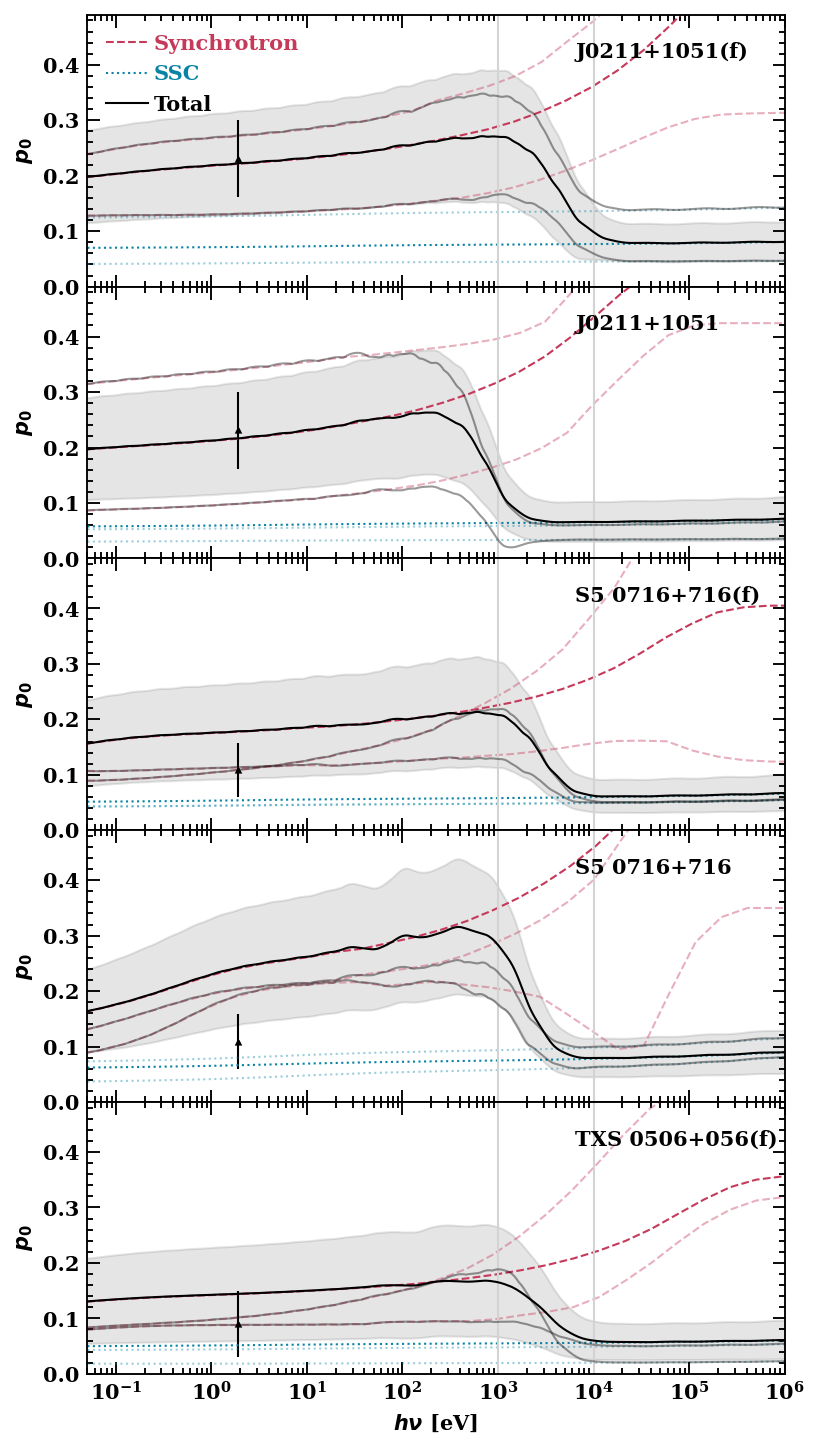

In [19]:
plot_name = 'pol_all_all'
names = ['J2011flare_19_g','J2011_19_g','S5flare_37_g','S5low_37_g','TXS_37_g']
samples = []
for n in names:
    s, mu, sigma = get_blazar_fit(n + '0',)
    samples.append(s)

# names_plot = ['J0211-flare','J0211','S50716-flare','S50716','TXS0506-flare']
names_plot = ['J0211+1051(f)', 'J0211+1051', 'S5 0716+716(f)', 'S5 0716+716', 'TXS 0506+056(f)']

fig, ax  = plt.subplots(figsize=(6,12), nrows=5, sharex=True,
                                  gridspec_kw={'hspace': 0, 'height_ratios': (0.2,0.2,0.2,0.2,0.2)})
_, pols,distances = get_data()
# iters = [[9,22,47],[19,21,59],[11,34,26],[16,0,30],[1,2,4]]
iters = [[9,47],[19,21],[34,26],[0,30],[2,4]]
# iters = [[i for i in range(60)] for _ in range(5)]
kwargs = dict(xlabel=True, distances=distances, iters=iters, save_data=True, names=names_plot)
plot_blazar_pols(samples, fig, ax, pols=pols, save=plot_name,**kwargs)

## Fit parameters table

/tmp/ipykernel_26421/1679640294.py:28: RuntimeWarning: invalid value encountered in sqrt
  print(t.format(*np.round(np.diag(np.sqrt(sigma)),2)))
/tmp/ipykernel_26421/1679640294.py:28: RuntimeWarning: invalid value encountered in sqrt
  print(t.format(*np.round(np.diag(np.sqrt(sigma)),2)))
/tmp/ipykernel_26421/1679640294.py:28: RuntimeWarning: invalid value encountered in sqrt
  print(t.format(*np.round(np.diag(np.sqrt(sigma)),2)))
/tmp/ipykernel_26421/1679640294.py:28: RuntimeWarning: invalid value encountered in sqrt
  print(t.format(*np.round(np.diag(np.sqrt(sigma)),2)))
/tmp/ipykernel_26421/1679640294.py:28: RuntimeWarning: invalid value encountered in sqrt
  print(t.format(*np.round(np.diag(np.sqrt(sigma)),2)))


CGRaBS~J0211+1051 (f) & $4.94 \pm 0.01$ & $13.4 \pm 0.01$ & $2.05 \pm 0.0 $ & $42.8 \pm 0.19$ & $14.8\pm 0.64$ & $5.04 \pm 0.02$ & $1.95\pm 0.18$ & $0.81\pm 0.01$\
CGRaBS~J0211+1051 & $6.48 \pm 0.02$ & $9.59 \pm 0.01$ & $1.85 \pm 0.01 $ & $41.9 \pm 0.35$ & $7.23\pm 0.15$ & $2.38 \pm 0.02$ & $2.31\pm 0.09$ & $0.83\pm 0.02$\
TXS~0506+056 & $5.26 \pm 0.05$ & $8.03 \pm 0.03$ & $1.89 \pm 0.01 $ & $32.1 \pm 0.26$ & $17.3\pm 0.42$ & $9.63 \pm 0.03$ & $1.64\pm 0.11$ & $0.98\pm 0.05$\
PKS~0716+714 (f) & $42.4 \pm 0.05$ & $13.4 \pm 0.03$ & $1.66 \pm 0.02 $ & $40.3 \pm 0.62$ & $13.2\pm 0.51$ & $2.84 \pm 0.06$ & $2.51\pm 0.06$ & $1.05\pm 0.02$\
PKS~0716+714 & $47.3 \pm 0.11$ & $9.49 \pm 0.15$ & $1.75 \pm 0.09 $ & $41.4 \pm 0.94$ & $17.0\pm 0.64$ & $3.23 \pm 0.15$ & $4.48\pm 0.16$ & $0.84\pm 0.13$\


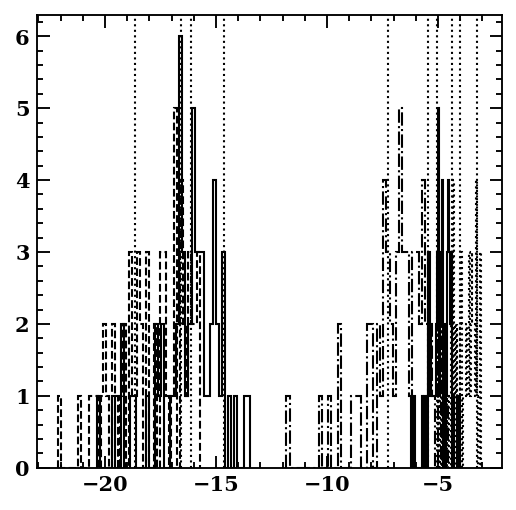

In [41]:
datas, _, distances = get_data()

text_list = ['CGRaBS~J0211+1051 (f) & $4.94 \pm {}$ & $13.4 \pm {}$ & $2.05 \pm {} $ & $42.8 \pm {}$ & $14.8\pm {}$ & $5.04 \pm {}$ & $1.95\pm {}$ & $0.81\pm {}$\\',
'CGRaBS~J0211+1051 & $6.48 \pm {}$ & $9.59 \pm {}$ & $1.85 \pm {} $ & $41.9 \pm {}$ & $7.23\pm {}$ & $2.38 \pm {}$ & $2.31\pm {}$ & $0.83\pm {}$\\',
'TXS~0506+056 & $5.26 \pm {}$ & $8.03 \pm {}$ & $1.89 \pm {} $ & $32.1 \pm {}$ & $17.3\pm {}$ & $9.63 \pm {}$ & $1.64\pm {}$ & $0.98\pm {}$\\',
'PKS~0716+714 (f) & $42.4 \pm {}$ & $13.4 \pm {}$ & $1.66 \pm {} $ & $40.3 \pm {}$ & $13.2\pm {}$ & $2.84 \pm {}$ & $2.51\pm {}$ & $1.05\pm {}$\\',
'PKS~0716+714 & $47.3 \pm {}$ & $9.49 \pm {}$ & $1.75 \pm {} $ & $41.4 \pm {}$ & $17.0\pm {}$ & $3.23 \pm {}$ & $4.48\pm {}$ & $0.84\pm {}$\\',]

for i, (data,n, errors, t) in enumerate(zip(datas, 
                                 ['J2011flare_19_g','J2011_19_g','S5flare_37_g','S5low_37_g','TXS_37_g'],
                                [0.6,0.4,0.45,0.5,0.45], text_list)):
    samples, mu, sigma = get_blazar_fit(n + '0',)
    dist_factor = 1.0E7*(1.0/((4.0*np.pi*distances[i][0]**2.0)*(1.0+distances[i][1])**2.0))
#     errors = err #np.quantile(data[:,3], 0.9)
    # errors = np.clip(data[:,3],np.quantile(data[:,3], 0.6),None)*1.8
    expected_loss = []
    loglikelihoods = []
    for S, IC in samples:
        loglike = -0.5*np.sum(((data[:,2] - np.log10(np.interp(10**data[:,0], IC[0,:], IC[1,:] * dist_factor) 
                                                + np.interp(10**data[:,0], S[0,:], S[1,:] * dist_factor)) )/ errors)**2 )
        loss = -2*loglike
        expected_loss.append(loss)
        loglikelihoods.append(loglike)
#     print(np.mean(expected_loss) / (len(data) - 8),'+-',np.sqrt(2*(len(data) - 8))/(len(data) - 8))
    sigma_rescale = 4.65 / (np.mean(np.sort(loglikelihoods)[-15:]) - np.quantile(loglikelihoods,q=1-0.68))
#     print("Rescale:", sigma_rescale)
    sigma = sigma * sigma_rescale
    print(t.format(*np.round(np.diag(np.sqrt(sigma)),2)))
    
    h = plt.hist(loglikelihoods, histtype='step')
    plt.axvline(np.quantile(loglikelihoods,q=1-0.68), ls=':')
    plt.axvline(np.mean(np.sort(loglikelihoods)[-15:]), ls=':')

## Individual: S5 0716+714 flare

/tmp/ipykernel_29486/2659260178.py:12: RuntimeWarning: invalid value encountered in log10
  Slog, IClog = np.log10(S), np.log10(IC)
/tmp/ipykernel_29486/2659260178.py:12: RuntimeWarning: divide by zero encountered in log10
  Slog, IClog = np.log10(S), np.log10(IC)
/tmp/ipykernel_29486/2659260178.py:24: RuntimeWarning: invalid value encountered in true_divide
  IC_Pi = np.sqrt(ICcopy[2]**2 + ICcopy[3]**2) / ICcopy[1]
/tmp/ipykernel_29486/2659260178.py:39: RuntimeWarning: invalid value encountered in log10
  log_samples_full.append((np.log10(Scopy),np.log10(ICcopy),np.log10(Totcopy)))
/tmp/ipykernel_29486/2659260178.py:39: RuntimeWarning: divide by zero encountered in log10
  log_samples_full.append((np.log10(Scopy),np.log10(ICcopy),np.log10(Totcopy)))
/share/software/user/open/py-numpy/1.20.3_py39/lib/python3.9/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


11 ratio:  0.287015973652525
34 ratio:  0.4356544879164596
26 ratio:  0.4660489875138892


2022-03-24 16:26:09,717 - matplotlib.font_manager - WARNING - findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
2022-03-24 16:26:09,719 - matplotlib.font_manager - WARNING - findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


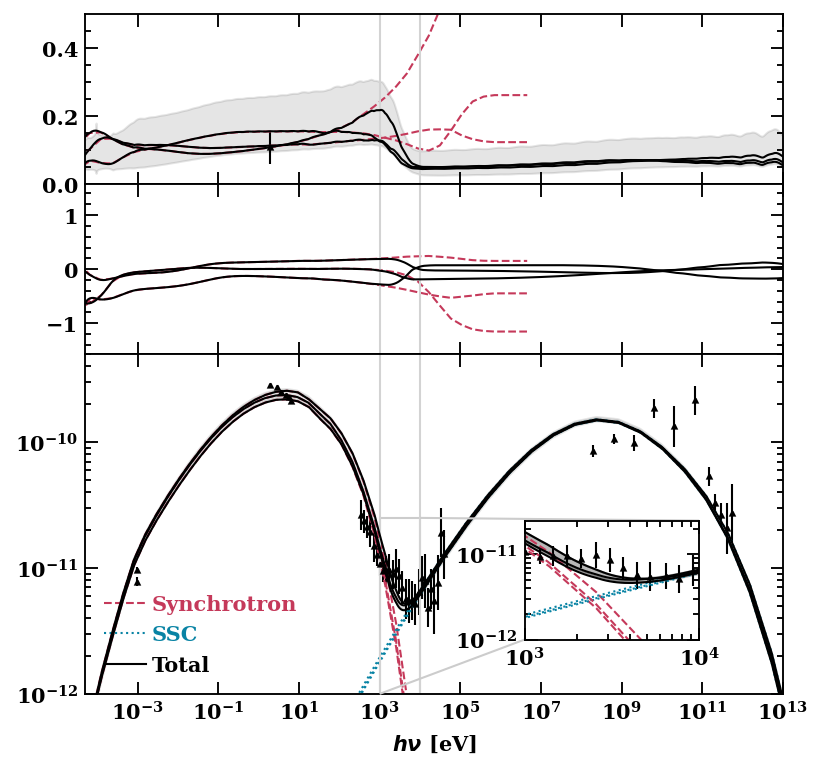

In [20]:
name = 'S5flare_37_g'
samples0, mu0, sigma0 = get_blazar_fit(name + '0',)
samples1, mu1, sigma1 = get_blazar_fit(name + '1',)

fig, (ax1,ax2,ax3)  = plt.subplots(figsize=(6,6), nrows=3, sharex=True,
                                  gridspec_kw={'hspace': 0, 'height_ratios': (0.25,0.25,0.5)})
ax4 = plt.axes([0,0,1,1])
data = np.loadtxt('../data/S5flare.txt')
kwargs = dict(inset_ylim=(1e-12, 2.5e-11), flux_ylim=(1e-12, 5e-10), n_samples=3, 
              ylabel=False, iters=[11,34,26])
plot_blazar([samples0,samples1], fig, ax=(ax1,ax2,ax3,ax4), data=data, 
            pol=(0.109,0.0489), d_blazar=1627E6*3.08E18, z=0.31, save=name,
           **kwargs)

## Individual: S5 0716+714 quiescent

/tmp/ipykernel_23521/2659260178.py:12: RuntimeWarning: invalid value encountered in log10
  Slog, IClog = np.log10(S), np.log10(IC)
/tmp/ipykernel_23521/2659260178.py:12: RuntimeWarning: divide by zero encountered in log10
  Slog, IClog = np.log10(S), np.log10(IC)
/tmp/ipykernel_23521/2659260178.py:24: RuntimeWarning: invalid value encountered in true_divide
  IC_Pi = np.sqrt(ICcopy[2]**2 + ICcopy[3]**2) / ICcopy[1]
/tmp/ipykernel_23521/2659260178.py:39: RuntimeWarning: invalid value encountered in log10
  log_samples_full.append((np.log10(Scopy),np.log10(ICcopy),np.log10(Totcopy)))
/tmp/ipykernel_23521/2659260178.py:39: RuntimeWarning: divide by zero encountered in log10
  log_samples_full.append((np.log10(Scopy),np.log10(ICcopy),np.log10(Totcopy)))
/share/software/user/open/py-numpy/1.20.3_py39/lib/python3.9/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


16 ratio:  0.0759101299435495
0 ratio:  0.36685418071983594
30 ratio:  0.5045564000381166


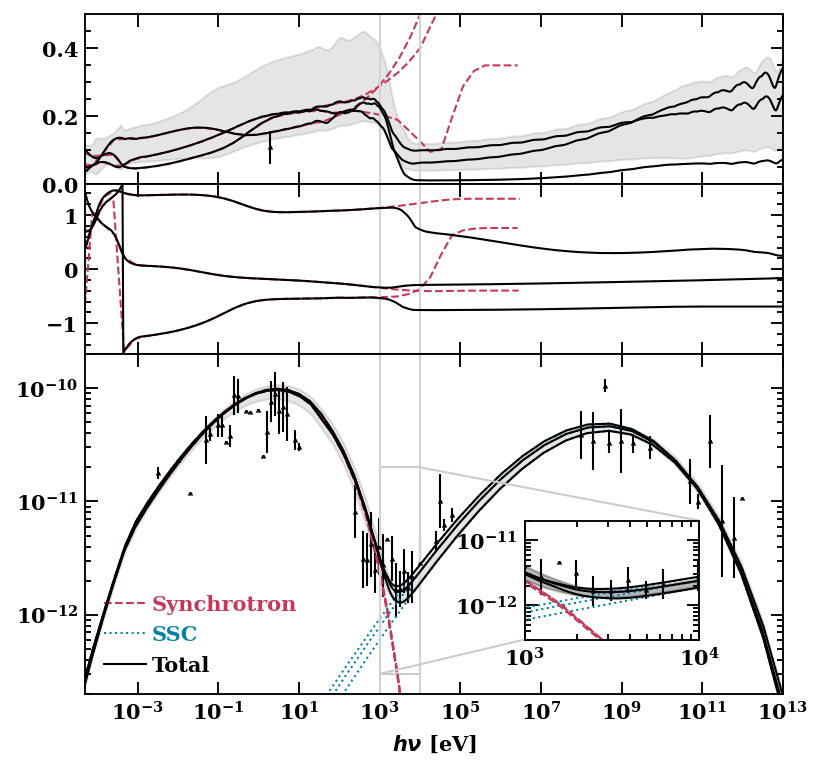

In [74]:
name = 'S5low_37_g'
samples0, mu0, sigma0 = get_blazar_fit(name + '0',)
samples1, mu1, sigma1 = get_blazar_fit(name + '1',)

fig, (ax1,ax2,ax3)  = plt.subplots(figsize=(6,6), nrows=3, sharex=True,
                                  gridspec_kw={'hspace': 0, 'height_ratios': (0.25,0.25,0.5)})
ax4 = plt.axes([0,0,1,1])
data = np.loadtxt('../data/S5low.txt')
data = np.insert(data, 1, 0, axis=1)
kwargs = dict(inset_ylim=(3e-13, 2e-11),flux_ylim=(2e-13, 2e-10),n_samples=3, 
              ylabel=False, iters=[16,0,30])
plot_blazar([samples0,samples1], fig, ax=(ax1,ax2,ax3,ax4), data=data, 
            pol=(0.109,0.0489), d_blazar=1627E6*3.08E18, z=0.31, save=name,
           **kwargs)

## Individual: TXS

/tmp/ipykernel_23521/2659260178.py:12: RuntimeWarning: divide by zero encountered in log10
  Slog, IClog = np.log10(S), np.log10(IC)
/tmp/ipykernel_23521/2659260178.py:12: RuntimeWarning: invalid value encountered in log10
  Slog, IClog = np.log10(S), np.log10(IC)
/tmp/ipykernel_23521/2659260178.py:23: RuntimeWarning: invalid value encountered in true_divide
  S_Pi = np.sqrt(Scopy[2]**2 + Scopy[3]**2) / Scopy[1]
/tmp/ipykernel_23521/2659260178.py:24: RuntimeWarning: invalid value encountered in true_divide
  IC_Pi = np.sqrt(ICcopy[2]**2 + ICcopy[3]**2) / ICcopy[1]
/tmp/ipykernel_23521/2659260178.py:39: RuntimeWarning: divide by zero encountered in log10
  log_samples_full.append((np.log10(Scopy),np.log10(ICcopy),np.log10(Totcopy)))
/tmp/ipykernel_23521/2659260178.py:39: RuntimeWarning: invalid value encountered in log10
  log_samples_full.append((np.log10(Scopy),np.log10(ICcopy),np.log10(Totcopy)))
/share/software/user/open/py-numpy/1.20.3_py39/lib/python3.9/site-packages/numpy/core/_m

1 ratio:  0.5012840776347032
2 ratio:  0.5641245779276941
4 ratio:  0.18525587506221536


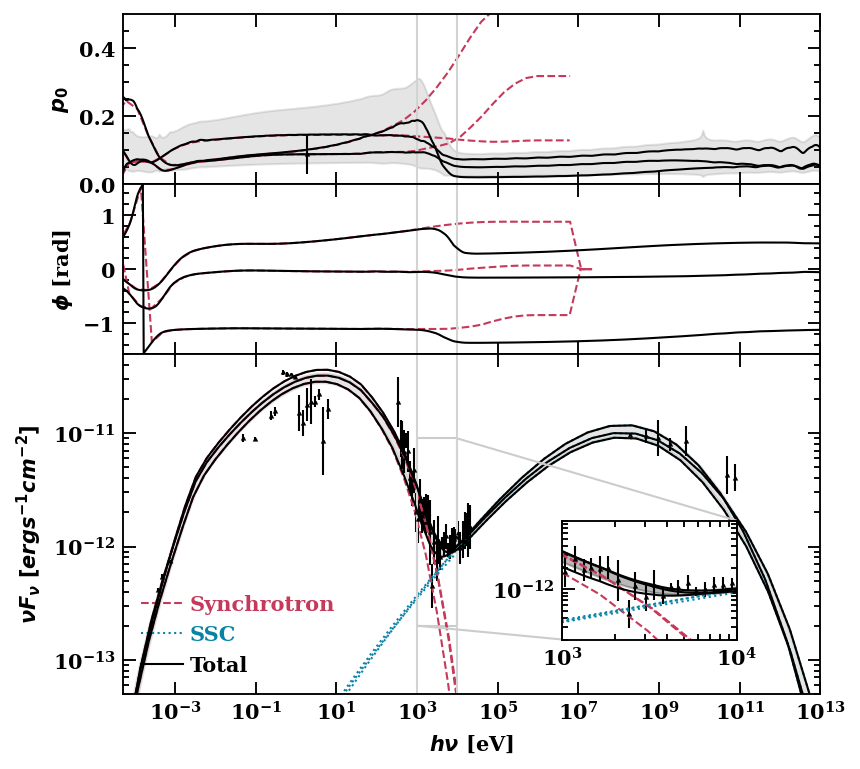

In [76]:
name = 'TXS_37_g'
samples0, mu0, sigma0 = get_blazar_fit(name + '0',)
samples1, mu1, sigma1 = get_blazar_fit(name + '1',)

fig, (ax1,ax2,ax3)  = plt.subplots(figsize=(6,6), nrows=3, sharex=True,
                                  gridspec_kw={'hspace': 0, 'height_ratios': (0.25,0.25,0.5)})
ax4 = plt.axes([0,0,1,1])
data = np.loadtxt('../data/txs.txt')
data = np.insert(data, 1, 0, axis=1)
kwargs = dict(inset_ylim=(2e-13, 9e-12),flux_ylim=(5e-14, 5e-11),n_samples=3, 
              ylabel=True, iters=[1,2,4])
plot_blazar([samples0,samples1], fig, ax=(ax1,ax2,ax3,ax4), data=data, 
            pol=(0.09,0.0589), d_blazar=1789E6*3.08E18, z=0.3365, save=name,
           **kwargs)

## Individual: J0211

/tmp/ipykernel_23521/2659260178.py:12: RuntimeWarning: divide by zero encountered in log10
  Slog, IClog = np.log10(S), np.log10(IC)
/tmp/ipykernel_23521/2659260178.py:12: RuntimeWarning: invalid value encountered in log10
  Slog, IClog = np.log10(S), np.log10(IC)
/tmp/ipykernel_23521/2659260178.py:23: RuntimeWarning: invalid value encountered in true_divide
  S_Pi = np.sqrt(Scopy[2]**2 + Scopy[3]**2) / Scopy[1]
/tmp/ipykernel_23521/2659260178.py:24: RuntimeWarning: invalid value encountered in true_divide
  IC_Pi = np.sqrt(ICcopy[2]**2 + ICcopy[3]**2) / ICcopy[1]
/tmp/ipykernel_23521/2659260178.py:39: RuntimeWarning: divide by zero encountered in log10
  log_samples_full.append((np.log10(Scopy),np.log10(ICcopy),np.log10(Totcopy)))
/tmp/ipykernel_23521/2659260178.py:39: RuntimeWarning: invalid value encountered in log10
  log_samples_full.append((np.log10(Scopy),np.log10(ICcopy),np.log10(Totcopy)))
/share/software/user/open/py-numpy/1.20.3_py39/lib/python3.9/site-packages/numpy/core/_m

19 ratio:  0.17912101985171883
21 ratio:  0.35393259205328204
59 ratio:  0.3300535266435299


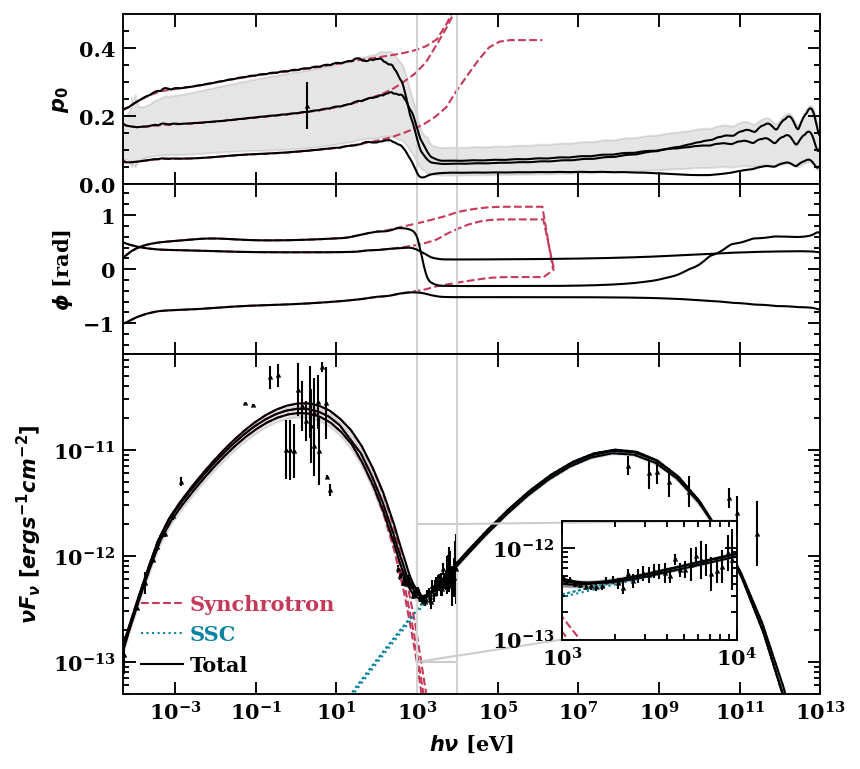

In [64]:
name = 'J2011_19_g'
samples0, mu0, sigma0 = get_blazar_fit(name + '0',)
samples1, mu1, sigma1 = get_blazar_fit(name + '1',)

fig, (ax1,ax2,ax3)  = plt.subplots(figsize=(6,6), nrows=3, sharex=True,
                                  gridspec_kw={'hspace': 0, 'height_ratios': (0.25,0.25,0.5)})
ax4 = plt.axes([0,0,1,1])
data = np.loadtxt('../data/new_data_sed_CGRaBSJ0211+1051.txt')
data_xmm = np.loadtxt('../data/new_data_sed_CGRaBSJ0211+1051_XMM.txt')
data = np.concatenate([data,data_xmm], axis=0)
kwargs = dict(inset_ylim=(1e-13, 2e-12), flux_ylim=(5e-14, 8e-11),n_samples=3, 
              ylabel=True, iters=[19,21,59])
plot_blazar([samples0,samples1], fig, ax=(ax1,ax2,ax3,ax4), data=data, 
            pol=(0.231,0.0693), d_blazar=1000E6*3.08E18, z=0.2, save=name,
           **kwargs)

## Individual: J0211 flaring state

/tmp/ipykernel_23521/2659260178.py:12: RuntimeWarning: invalid value encountered in log10
  Slog, IClog = np.log10(S), np.log10(IC)
/tmp/ipykernel_23521/2659260178.py:12: RuntimeWarning: divide by zero encountered in log10
  Slog, IClog = np.log10(S), np.log10(IC)
/tmp/ipykernel_23521/2659260178.py:24: RuntimeWarning: invalid value encountered in true_divide
  IC_Pi = np.sqrt(ICcopy[2]**2 + ICcopy[3]**2) / ICcopy[1]
/tmp/ipykernel_23521/2659260178.py:39: RuntimeWarning: divide by zero encountered in log10
  log_samples_full.append((np.log10(Scopy),np.log10(ICcopy),np.log10(Totcopy)))
/tmp/ipykernel_23521/2659260178.py:39: RuntimeWarning: invalid value encountered in log10
  log_samples_full.append((np.log10(Scopy),np.log10(ICcopy),np.log10(Totcopy)))
/tmp/ipykernel_23521/2659260178.py:23: RuntimeWarning: invalid value encountered in true_divide
  S_Pi = np.sqrt(Scopy[2]**2 + Scopy[3]**2) / Scopy[1]
/share/software/user/open/py-numpy/1.20.3_py39/lib/python3.9/site-packages/numpy/core/_m

9 ratio:  0.49917682757023624
22 ratio:  0.39220731925688035
47 ratio:  0.34314546043688465


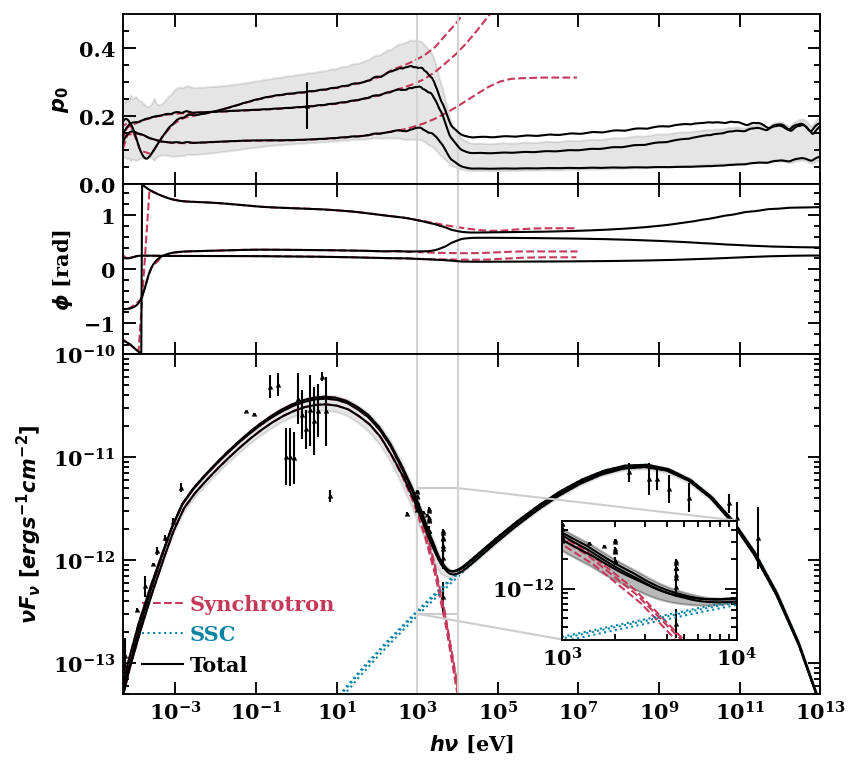

In [70]:
name = 'J2011flare_19_g'
samples0, mu0, sigma0 = get_blazar_fit(name + '0',)
samples1, mu1, sigma1 = get_blazar_fit(name + '1',)

fig, (ax1,ax2,ax3)  = plt.subplots(figsize=(6,6), nrows=3, sharex=True,
                                  gridspec_kw={'hspace': 0, 'height_ratios': (0.25,0.25,0.5)})
ax4 = plt.axes([0,0,1,1])
data = np.loadtxt('../data/new_data_sed_CGRaBSJ0211+1051.txt')
data_xmm = np.loadtxt('../data/CGRaBSJ02111051-builderX.txt')
data = np.concatenate([data,data_xmm], axis=0)
kwargs = dict(inset_ylim=(3e-13, 5e-12),flux_ylim=(5e-14, 1e-10),n_samples=3, 
              ylabel=True, iters=[9,22,47])
plot_blazar([samples0,samples1], fig, ax=(ax1,ax2,ax3,ax4), data=data, 
            pol=(0.231,0.0693), d_blazar=1000E6*3.08E18, z=0.2, save=name,
           **kwargs)

<AxesSubplot:>

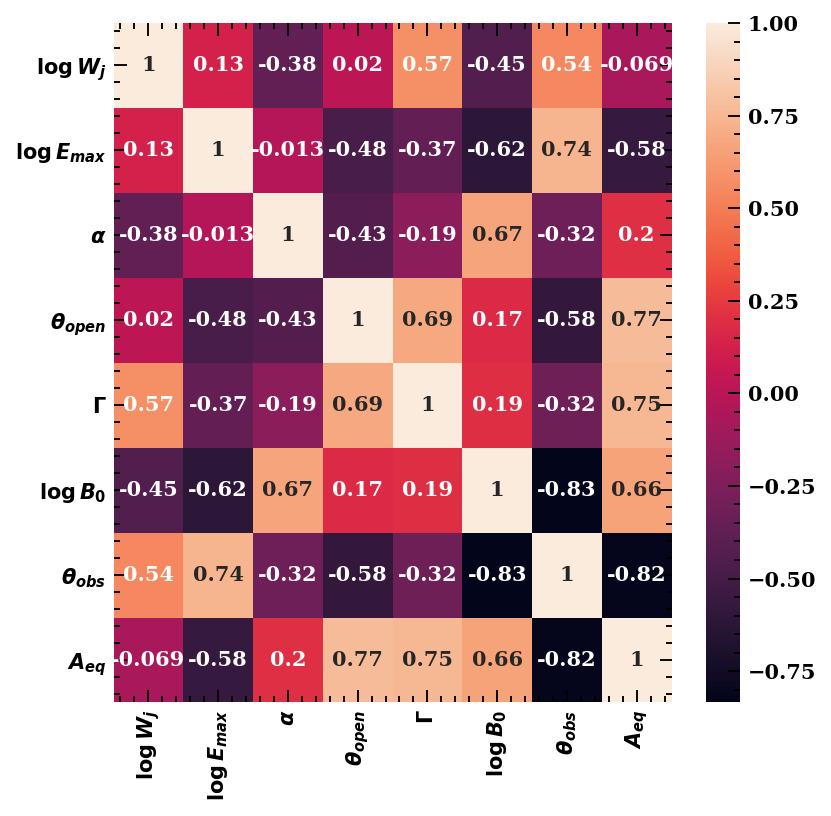

In [73]:
fig, ax = plt.subplots(figsize=(6,6))
corr = np.sqrt(np.diag(np.diag(1/sigma)))@sigma@np.sqrt(np.diag(np.diag(1/sigma)))
varlab = [r'$\logW_j$', r'$\logE_{max}$', r'$\alpha$', r'$\theta_{open}$', r'$\Gamma$', 
             r'$\logB_0$', r'$\theta_{obs}$', r'$A_{eq}$']
sns.heatmap(corr[:8,:8],annot=True,
            xticklabels=varlab,
            yticklabels=varlab, ax=ax)

/tmp/ipykernel_28751/1826617118.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (alpha_ic,A_ic),_,_,_ = np.linalg.lstsq(np.stack([np.log(IC[0].T[(IC[0] < 4e4)*(IC[0] > 5e2)]/1e3),
/tmp/ipykernel_28751/1826617118.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (alpha_s,A_s),_,_,_ = np.linalg.lstsq(np.stack([np.log(S[0].T[(S[0] < 1e4)*(S[0] > 1e3)]/1e3),
/tmp/ipykernel_28751/1826617118.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are th

(2.0, 8.0)

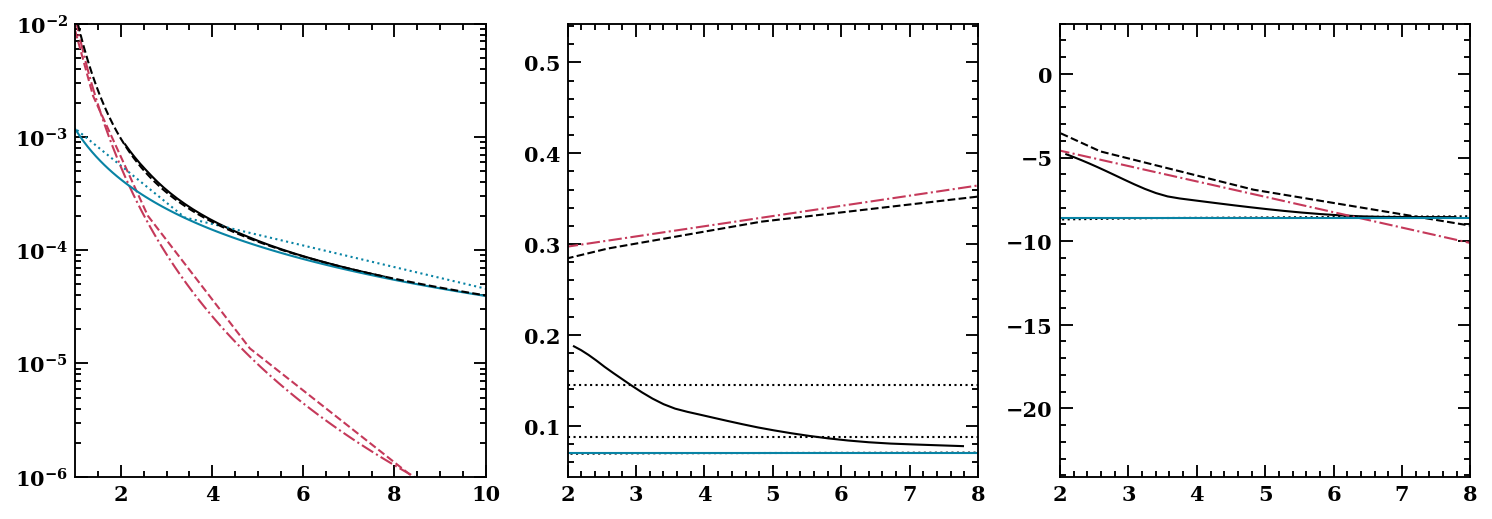

In [6]:
idx = 1
Tot = np.load("../tracksml/moments/ixpeobssimdata/S50716/"+'Tot_'+name+"0_"+str(idx)+".npy")
S = np.load("../tracksml/moments/ixpeobssimdata/S50716/"+'S_'+name+"0_"+str(idx)+".npy")
IC = np.load("../tracksml/moments/ixpeobssimdata/S50716/"+'IC_'+name+"0_"+str(idx)+".npy")
interp_kind = 'quadratic'


(alpha_ic,A_ic),_,_,_ = np.linalg.lstsq(np.stack([np.log(IC[0].T[(IC[0] < 4e4)*(IC[0] > 5e2)]/1e3), 
                          np.ones(len(IC[0].T[(IC[0] < 4e4)*(IC[0] > 5e2)]))],axis=1), 
                np.log((IC[1] * (6.242e+11 / (IC[0]*IC[0])) * 1e3).T[(IC[0] < 4e4)*(IC[0] > 5e2)]))

(alpha_s,A_s),_,_,_ = np.linalg.lstsq(np.stack([np.log(S[0].T[(S[0] < 1e4)*(S[0] > 1e3)]/1e3), 
                          np.ones(len(S[0].T[(S[0] < 1e4)*(S[0] > 1e3)]))],axis=1), 
                np.log((S[1] * (6.242e+11 / (S[0]*S[0])) * 1e3).T[(S[0] < 1e4)*(S[0] > 1e3)]))

(alpha_pi_s, A_pi_s),_,_,_ = np.linalg.lstsq(np.stack([S[0].T[(S[0] < 1e4)*(S[0] > 1e3)]/1e3 - 1, 
                          np.ones(len(S[0].T[(S[0] < 1e4)*(S[0] > 1e3)]))],axis=1), 
                S[2].T[(S[0] < 1e4)*(S[0] > 1e3)])

(alpha_phi_s, A_phi_s),_,_,_ = np.linalg.lstsq(np.stack([S[0].T[(S[0] < 1e4)*(S[0] > 1e3)]/1e3 - 1, 
                          np.ones(len(S[0].T[(S[0] < 1e4)*(S[0] > 1e3)]))],axis=1), 
                S[3].T[(S[0] < 1e4)*(S[0] > 1e3)] * 180/np.pi)

pi_ic = np.mean(IC[2].T[(IC[0] < 4e4)*(IC[0] > 5e2)])
phi_ic = np.mean(IC[3].T[(IC[0] < 4e4)*(IC[0] > 5e2)] * 180/np.pi)

interpolate.interp1d(S[0], S[1], fill_value=0, bounds_error=False, kind=interp_kind)(Tot[0])
interpolate.interp1d(S[0], S[2], fill_value=0, bounds_error=False, kind=interp_kind)(Tot[0])

mask = (Tot[0] < 4e3)*(Tot[0] > 2e3)
pi_2_4 = (np.sqrt(np.sum(Tot[0][mask] * Tot[1][mask] * Tot[2][mask] * np.cos(2*Tot[3][mask]))**2 
                    + np.sum(Tot[0][mask] * Tot[1][mask] * Tot[2][mask] * np.sin(2*Tot[3][mask]))**2)
          / np.sum(Tot[0][mask] * Tot[1][mask]))

mask = (Tot[0] < 8e3)*(Tot[0] > 4e3)
pi_4_8 = (np.sqrt(np.sum(Tot[0][mask] * Tot[1][mask] * Tot[2][mask] * np.cos(2*Tot[3][mask]))**2 
                    + np.sum(Tot[0][mask] * Tot[1][mask] * Tot[2][mask] * np.sin(2*Tot[3][mask]))**2)
          / np.sum(Tot[0][mask] * Tot[1][mask]))

#effectively broken power law
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(12,4), ncols=3,)
ax1.plot(Tot[0].T[(Tot[0] < 8e3)*(Tot[0] > 2e3)]/1e3,
         (Tot[1] * (6.242e+11 / (Tot[0]*Tot[0])) * 1e3).T[(Tot[0] < 8e3)*(Tot[0] > 2e3)])
ax1.plot(S[0].T[(S[0] < 8e4)*(S[0] > 2e2)]/1e3,
         (S[1] * (6.242e+11 / (S[0]*S[0])) * 1e3).T[(S[0] < 8e4)*(S[0] > 2e2)], color=sync_c)
ax1.plot(IC[0].T[(IC[0] < 8e4)*(IC[0] > 2e1)]/1e3,
         (IC[1] * (6.242e+11 / (IC[0]*IC[0])) * 1e3).T[(IC[0] < 8e4)*(IC[0] > 2e1)], color=ic_c)
x = np.linspace(1,10,100)
ax1.plot(x, np.exp(A_s) * x ** alpha_s,color=sync_c)
ax1.plot(x, np.exp(A_ic) * x ** alpha_ic, color=ic_c)
ax1.plot(x, np.exp(A_s) * x ** alpha_s + np.exp(A_ic) * x ** alpha_ic)

ax1.set_yscale('log')
ax1.set_xlim(1,10)
ax1.set_ylim(1e-6,1e-2)

ax2.plot(Tot[0].T[(Tot[0] < 8e3)*(Tot[0] > 2e3)]/1e3,
         Tot[2].T[(Tot[0] < 8e3)*(Tot[0] > 2e3)])
ax2.plot(S[0].T[(S[0] < 8e4)*(S[0] > 2e2)]/1e3,
         S[2].T[(S[0] < 8e4)*(S[0] > 2e2)])
ax2.plot(IC[0].T[(IC[0] < 8e4)*(IC[0] > 2e1)]/1e3,
         IC[2].T[(IC[0] < 8e4)*(IC[0] > 2e1)])
ax2.plot(x,  A_pi_s + x * alpha_pi_s, color=sync_c)
ax2.axhline(pi_ic, color=ic_c)
ax2.axhline(pi_2_4,ls=':')
ax2.axhline(pi_4_8,ls=':')
ax2.set_xlim(2,8)
# ax2.set_yscale('log')
# ax2.set_xscale('log')


ax3.plot(Tot[0].T[(Tot[0] < 8e3)*(Tot[0] > 2e3)]/1e3,
         Tot[3].T[(Tot[0] < 8e3)*(Tot[0] > 2e3)] * 180/np.pi)
ax3.plot(S[0].T[(S[0] < 8e4)*(S[0] > 2e2)]/1e3,
         S[3].T[(S[0] < 8e4)*(S[0] > 2e2)] * 180/np.pi)
ax3.plot(IC[0].T[(IC[0] < 8e4)*(IC[0] > 2e1)]/1e3,
         IC[3].T[(IC[0] < 8e4)*(IC[0] > 2e1)] * 180/np.pi)
ax3.plot(x,  A_phi_s + x * alpha_phi_s, color=sync_c)
ax3.axhline(phi_ic, color=ic_c)
ax3.set_xlim(2,8)

# ax3.plot(x, [89.6378]*len(x))